# WeatherPy 

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import json 
import requests
import time
import scipy.stats as sts
from scipy import stats
import openweathermapy.core as owm
import csv 

#Import API Key
from config import weather_api_key

# to get the city latitude and longtiude 
from citipy import citipy

# Range of latitudes and longitudes
#https://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/about-geographic-coordinate-systems.htm
lat_range = (-90, 90)
lng_range = (-180, 180)

# Cities Summary 

In [7]:
#Set up lists to hold reponse info for latitude and lontitude
lat_lngs = []
cities = []
countries = []

#Get the random lat and lng then zip together
#https://stackoverflow.com/questions/55230785/how-can-i-generate-a-seed-for-np-random-uniform
lats = np.random.uniform(low=-90.00, high=90.00, size=1500)
lngs = np.random.uniform(low=-180.00, high=180.00, size=1500)
lat_lngs = zip(lats, lngs)


#Get the nearest city based on latitude and lontitude
#https://github.com/wingchen/citipy/blob/master/tests.py
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    if city not in cities:
        cities.append(city)
        countries.append(country)

#Create DataFrame for city and country         
City_latlong_data = pd.DataFrame({"City": cities, "Country": countries})
City_latlong_data = City_latlong_data.reset_index(drop=True)
City_latlong_data.head() 

#set up additional columns to hold information
City_latlong_data["Cloudiness"] = ""
City_latlong_data["Humidity"] = ""
City_latlong_data["Date"] = ""
City_latlong_data["Max Temp"] = ""
City_latlong_data["Wind Speed"] = ""

#Print the city count
len(cities)

610

In [8]:
#Create a dataframe to store all the latitude and longitude
Cities_df = pd.DataFrame()
Cities_df = Cities_df.append(pd.DataFrame.from_dict({ "Latitude": lats, "Longitude": lngs}))        
Cities_df

#Merge two dataframes to display all the additional columns, drop duplicates and drop nan vaulues
City_Data = [City_latlong_data, Cities_df]        
City_Data_DF = pd.concat([City_latlong_data, Cities_df], axis=1)
City_Data_DF = City_Data_DF.drop_duplicates()
City_Data_DF = City_Data_DF.dropna()
City_Data_DF = City_Data_DF.reset_index(drop=True)
City_Data_DF = pd.DataFrame(City_Data_DF)
City_Data_DF.head(20)

,City,Country,Cloudiness,Humidity,Date,Max Temp,Wind Speed,Latitude,Longitude
0,barra do bugres,br,,,,,,-15.019109,-57.214984
1,rikitea,pf,,,,,,-72.587668,-122.984423
2,cape town,za,,,,,,-47.663398,-6.204036
3,punta arenas,cl,,,,,,-87.860162,-120.862979
4,west bay,ky,,,,,,19.921330,-81.697971
5,glens falls,us,,,,,,43.772567,-73.619159
6,qaanaaq,gl,,,,,,76.530475,-88.417463
7,kaitangata,nz,,,,,,-56.265853,174.397426
8,beyneu,kz,,,,,,42.984977,56.412787
9,lompoc,us,,,,,,-47.138627,2.369153


In [9]:
##* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
random_selected_cities = City_Data_DF.sample(500)
#Print the selected cities Dataframe
random_selected_cities = random_selected_cities.reset_index(drop=True)
random_selected_cities = pd.DataFrame(random_selected_cities)
random_selected_cities

,City,Country,Cloudiness,Humidity,Date,Max Temp,Wind Speed,Latitude,Longitude
0,sokolo,ml,,,,,,-16.956878,-139.560882
1,anadyr,ru,,,,,,-4.979394,49.713133
2,uzventis,lt,,,,,,-56.907463,37.057590
3,sergeyevka,kz,,,,,,-34.996260,-163.678191
4,bethel,us,,,,,,38.171652,158.477701
...,...,...,...,...,...,...,...,...,...
495,omboue,ga,,,,,,83.232703,-118.212788
496,khormuj,ir,,,,,,-49.063939,89.473612
497,ushuaia,ar,,,,,,85.835648,-140.348510
498,grindavik,is,,,,,,-45.190116,-0.010980


# Get API Calls¶

In [10]:
#https://gt.bootcampcontent.com/GT-Coding-Boot-Camp/gt-atl-data-pt-03-2020-u-c/blob/master/06-Python-APIs/3/Activities/04-Ins_NearestRestr/Solved/NearestRestr.ipynb
#URL for get requests to retrieve weather data - 
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + weather_api_key
print(url)
     
# set up lists to hold reponse info
city_name =[]
lat = []
lon = []
temp =[]
temperature_max = []
date = []
humidity = []
wind_speed = []
country = []
cloudiness = []

#counter for data set number of calls
record_count = 1

# Loop through the list of cities and perform a request
#Used Activity 06-Python-APIs/2/Activities/10-Stu_API_Exceptions/Solved/api_exceptions.ipynb
print(f"Generating Data Retrival")

for city in cities:
    
# Try to grab the lists of city responses if availble from json response
    try:
        response = requests.get(f"{url}&q={city}").json()
        #Making sure my url printed 
#        print(response)
        city_name.append(response['name'])
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temperature_max.append(response['main']['temp_max'])
        date.append(response['dt'])
        humidity.append(response['main']['humidity'])
        wind_speed.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        cloudiness.append(response['clouds']['all'])
        city = response['name']
        print(f"The weather API responded with:# {record_count} | {city}")
        record_count = record_count + 1

        # API CALLS TO SLEEP FOR 1 SECONDS DUE TO FREE 60 CALLS/MIN 
        time.sleep(1)
        
    
    except KeyError: 
        print("City missing...Skipping")
        
print("------------------------")
print("Generated Data Completed")
print("------------------------")

http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=9246be5369046e9d6295393ab5911965
Generating Data Retrival
The weather API responded with:# 1 | Barra do Bugres
The weather API responded with:# 2 | Rikitea
The weather API responded with:# 3 | Cape Town
The weather API responded with:# 4 | Punta Arenas
The weather API responded with:# 5 | West Bay
The weather API responded with:# 6 | Glens Falls
The weather API responded with:# 7 | Qaanaaq
The weather API responded with:# 8 | Kaitangata
The weather API responded with:# 9 | Beyneu
The weather API responded with:# 10 | Lompoc
The weather API responded with:# 11 | Busselton
The weather API responded with:# 12 | Upernavik
The weather API responded with:# 13 | Tiksi
The weather API responded with:# 14 | Le Mars
The weather API responded with:# 15 | Grand-Santi
City missing...Skipping
The weather API responded with:# 16 | Lakatoro
City missing...Skipping
The weather API responded with:# 17 | Tuktoyaktuk
The weather API respo

In [11]:
#checking the counts and making sure the information is there needed
# ERROR RECEIVED ABOUT valueerror: arrays must all be same length
print(len(cities), len(country), len(cloudiness), len(humidity), len(date), len(temperature_max),
     len(wind_speed), len(lat), len(lon))

610 553 553 553 553 553 553 553 553


# RAW DATA 

In [12]:
city_weatherpy_dict = {"City": cities, "Country": country, 
                       "Cloudiness %": cloudiness, "Humidity": humidity,
                       "Date": date, "Max Temp (F)": temperature_max,
                       "Wind Speed (mph)": wind_speed, "Latitude": lat,
                       "Longitude": lon
                      }
city_weatherpy_data = pd.DataFrame.from_dict(city_weatherpy_dict, orient='index')
city_weatherpy_data.transpose()

,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,barra do bugres,BR,63,73,1587686372,73.89,1.63,-15.07,-57.18
1,rikitea,PF,0,77,1587686449,75.74,13.67,-23.12,-134.97
2,cape town,ZA,95,77,1587686405,63,5.82,-33.93,18.42
3,punta arenas,CL,40,70,1587686452,42.8,9.17,-53.15,-70.92
4,west bay,KY,3,72,1587686453,84,1.01,19.37,-81.42
...,...,...,...,...,...,...,...,...,...
605,havre-saint-pierre,None,None,None,None,None,None,None,None
606,portel,None,None,None,None,None,None,None,None
607,sumeg,None,None,None,None,None,None,None,None
608,lac du bonnet,None,None,None,None,None,None,None,None


In [13]:
# When I printed my code the columns were labeled as the rows vice versa so I found I needed to use T to transpose the data back. It fixed the issue and I was also able to print the csv file correctly as well. 
transposed_data = city_weatherpy_data.T
transposed_data

,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,barra do bugres,BR,63,73,1587686372,73.89,1.63,-15.07,-57.18
1,rikitea,PF,0,77,1587686449,75.74,13.67,-23.12,-134.97
2,cape town,ZA,95,77,1587686405,63,5.82,-33.93,18.42
3,punta arenas,CL,40,70,1587686452,42.8,9.17,-53.15,-70.92
4,west bay,KY,3,72,1587686453,84,1.01,19.37,-81.42
...,...,...,...,...,...,...,...,...,...
605,havre-saint-pierre,None,None,None,None,None,None,None,None
606,portel,None,None,None,None,None,None,None,None
607,sumeg,None,None,None,None,None,None,None,None
608,lac du bonnet,None,None,None,None,None,None,None,None


In [14]:
#Droping the empty rows that are listed as none above which leaves me with 577 cities
transposed_data.dropna(inplace=True)
transposed_data

,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,barra do bugres,BR,63,73,1587686372,73.89,1.63,-15.07,-57.18
1,rikitea,PF,0,77,1587686449,75.74,13.67,-23.12,-134.97
2,cape town,ZA,95,77,1587686405,63,5.82,-33.93,18.42
3,punta arenas,CL,40,70,1587686452,42.8,9.17,-53.15,-70.92
4,west bay,KY,3,72,1587686453,84,1.01,19.37,-81.42
...,...,...,...,...,...,...,...,...,...
548,invermere,CA,90,80,1587686882,30.2,24.16,50.23,-63.6
549,altamira,BR,98,96,1587687174,73.9,2.48,-1.94,-50.82
550,split,HU,0,80,1587687175,41,2.24,46.98,17.28
551,belaya gora,CA,38,40,1587687177,55,8.99,50.25,-96.06


In [15]:
#Output for my csv file
transposed_data.to_csv("./output_data/what_weatherpy_data.csv") 

In [16]:
#Read my Output file to make sure data is formatted correctly for my csv file
transposed_data = pd.read_csv("./output_data/what_weatherpy_data.csv")
transposed_data.head()

,Unnamed: 0,City,Country,Cloudiness %,Humidity,Date,Max Temp (F),Wind Speed (mph),Latitude,Longitude
0,0,barra do bugres,BR,63,73,1587686372,73.89,1.63,-15.07,-57.18
1,1,rikitea,PF,0,77,1587686449,75.74,13.67,-23.12,-134.97
2,2,cape town,ZA,95,77,1587686405,63.00,5.82,-33.93,18.42
3,3,punta arenas,CL,40,70,1587686452,42.80,9.17,-53.15,-70.92
4,4,west bay,KY,3,72,1587686453,84.00,1.01,19.37,-81.42


# Plotting the Data - Latitude VS Temperature (F) plot 
    * Save a CSV of all retrieved data and a PNG image for each scatter plot.
    * You must use proper labeling of your plots, including aspects like: Plot Titles (with date of analysis) and Axes Labels.
    * For max intensity in the heat map, try setting it to the highest humidity found in the data set.

In [17]:
from datetime import datetime
date_stamp = datetime.date(datetime.now())
print(date_stamp)

2020-04-23


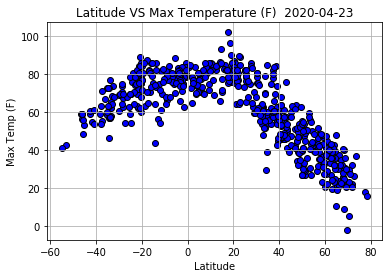

In [38]:
#Plotting the Data - Latitude VS Temperature (F) plot 
x_values = transposed_data['Latitude']
y_values = transposed_data['Max Temp (F)']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")

plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
plt.title(f"Latitude VS Max Temperature (F)  {date_stamp}")
plt.grid()
plt.savefig("./output_data/Latitude_VS_MaxTemperature.png")
plt.show()

#After each plot add a sentence or too explaining what the code is and analyzing.


*The scatter above is showing the relationship between latitude vs max temperature. As the city position is closer to the latitude of the Equator which is 0 the temps are above 70 degrees or more. If the latitude if farther away from the Equator the tempertature will decrease. 

# Humidity (%) vs. Latitude

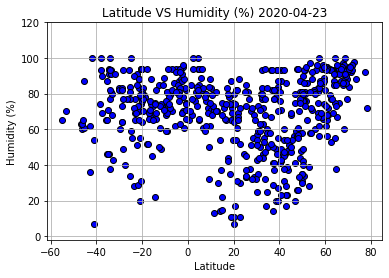

In [39]:
#Create a scatter plot for Humidity (%) vs. Latitude
x_values = transposed_data['Latitude']
y_values = transposed_data['Humidity']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.ylim(-2, 120)
plt.title(f"Latitude VS Humidity (%) {date_stamp}")
plt.savefig("./output_data/Latitude_VS_Humidity.png")
plt.show()

#After each plot add a sentence or too explaining what the code is and analyzing.
    After looking at the scatter plot it looks like there are a several cities with high humidity % around 70% to 100% near the Equator and also between 60Lat to 80Lat shows a significant number of high humidity above 80%.

# Cloudiness (%) vs. Latitude

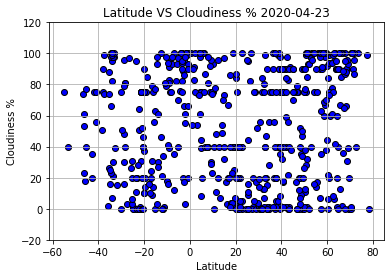

In [40]:
#Create a scatter plot for Cloudiness (%) vs. Latitude
x_values = transposed_data['Latitude']
y_values = transposed_data['Cloudiness %']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Cloudiness %')
plt.ylim(-20, 120)
plt.title(f"Latitude VS Cloudiness % {date_stamp}")
plt.savefig("./output_data/Latitude_VS_Cloudiness.png")
plt.show()

There doesn't seem to be any relationship between the cloudiness and the position of the cities. 

# Wind Speed (mph) vs. Latitude

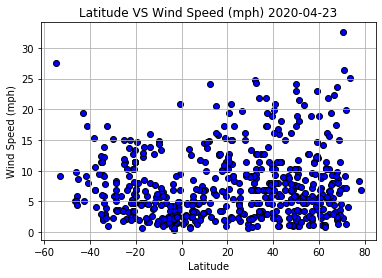

In [41]:
#Create a scatter plot for Wind Speed (mph) vs. Latitude
x_values = transposed_data['Latitude']
y_values = transposed_data['Wind Speed (mph)']
plt.scatter(x_values, y_values, c="blue", edgecolors="black")
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f"Latitude VS Wind Speed (mph) {date_stamp}")
plt.savefig("./output_data/Latitude_VS_WindSpeed.png")
plt.show()

There doesn't seem to be a difference in the wind speed and the position of the cities. There are multiple cities with a wind speed of 0 to 5 between the latitude of -40 to 70 in the southern area. But there are very minimial windspeeds in the northern part of the graph. 

# Create a linear regression plot & Create the DataFrames for the hemispheres 

#Your second requirement is to run linear regression on each relationship, only this time separating them into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 degrees latitude):

* Northern Hemisphere - Temperature (F) vs. Latitude
* Southern Hemisphere - Temperature (F) vs. Latitude
* Northern Hemisphere - Humidity (%) vs. Latitude
* Southern Hemisphere - Humidity (%) vs. Latitude
* Northern Hemisphere - Cloudiness (%) vs. Latitude
* Southern Hemisphere - Cloudiness (%) vs. Latitude
* Northern Hemisphere - Wind Speed (mph) vs. Latitude
* Southern Hemisphere - Wind Speed (mph) vs. Latitude

In [42]:
#Northern Hemipshere is everything above the Equator >= 0
#Southern Hemipshere is everything below the Equator < 0
North_Hem_df = transposed_data[transposed_data["Latitude"]>= 0]
South_Hem_df = transposed_data[transposed_data["Latitude"]< 0]

# Northern Hemisphere - Temperature (F) vs. Latitude

The r-squared is: 0.7763333170746828


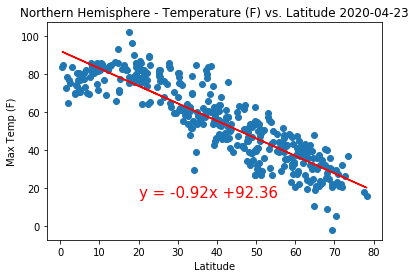

In [43]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

# Create a Scatter Plot for temperature vs latitude
x_values = North_Hem_df['Latitude']
y_values = North_Hem_df['Max Temp (F)']

 # Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

# Create Plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label plot and annotate the line equation
plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
plt.title(f"Northern Hemisphere - Temperature (F) vs. Latitude {date_stamp}")
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
     
plt.savefig("./output_data/NorthernHemisphereTemperatureVSLatitude.png")
 
# Print r square value
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Southern Hemisphere - Temperature (F) vs. Latitude

The r-squared is: 0.4224996265470192


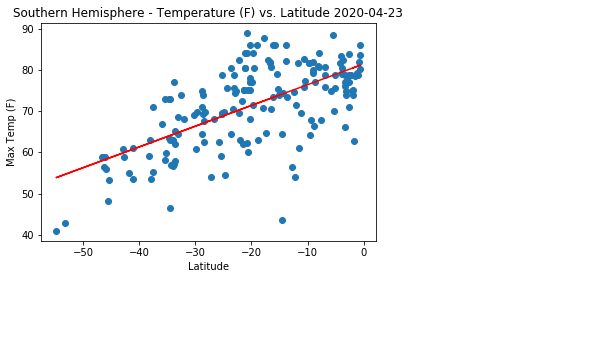

In [44]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = South_Hem_df['Latitude']
y_values = South_Hem_df['Max Temp (F)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
plt.title(f"Southern Hemisphere - Temperature (F) vs. Latitude {date_stamp}")


# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereTemperatureVSLatitude.png")
plt.show()

# Northern Hemisphere - Humidity (%) vs. Latitude

The r-squared is: 0.06444041334134383


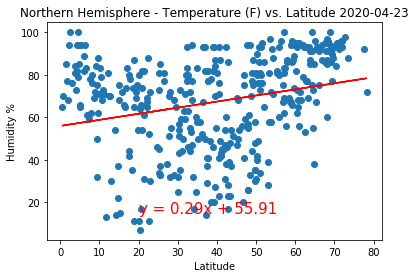

In [45]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = North_Hem_df['Latitude']
y_values = North_Hem_df['Humidity']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity %')
plt.title(f"Northern Hemisphere - Temperature (F) vs. Latitude {date_stamp}")

# Print r square value
print(f"The r-squared is: {rvalue**2}")
plt.savefig("./output_data/NorthernHemisphereHumidityVSLatitude.png")
plt.show()

# Southern Hemisphere - Humidity (%) vs. Latitude

The r-squared is: 0.038968343310307046


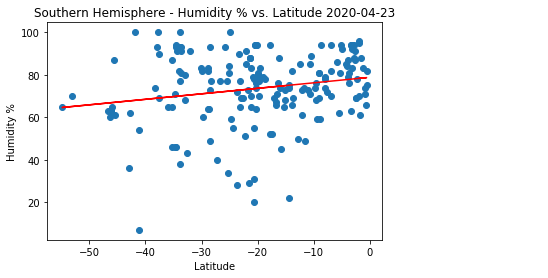

In [46]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = South_Hem_df["Latitude"]
y_values = South_Hem_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity %')
plt.title(f"Southern Hemisphere - Humidity % vs. Latitude {date_stamp}")

# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereHumidityVSLatitude.png")
plt.show()

# Northern Hemisphere - Cloudiness (%) vs. Latitude

The r-squared is: 0.024349801430951497


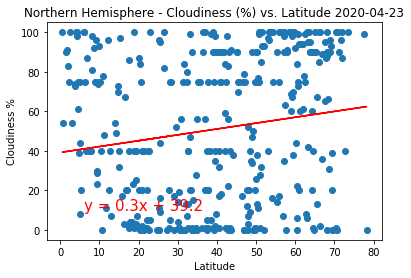

In [47]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = North_Hem_df["Latitude"]
y_values = North_Hem_df["Cloudiness %"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness %')
plt.title(f"Northern Hemisphere - Cloudiness (%) vs. Latitude {date_stamp}")

# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/NorthernHemisphereCloudinessVSLatitude.png")
plt.show()

# Southern Hemisphere - Cloudiness (%) vs. Latitude

The r-squared is: 0.03474113450503139


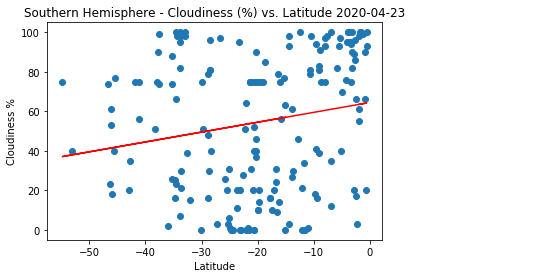

In [48]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = South_Hem_df["Latitude"]
y_values = South_Hem_df["Cloudiness %"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness %')
plt.title(f"Southern Hemisphere - Cloudiness (%) vs. Latitude {date_stamp}")

# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereCloudinessVSLatitude.png")
plt.show()

# Northern Hemisphere - Wind Speed (mph) vs. Latitude

The r-squared is: 0.008719520255879418


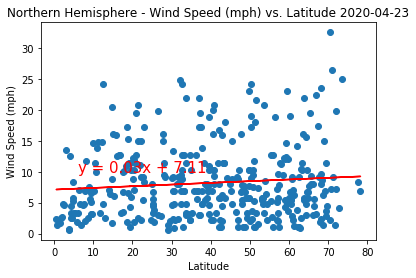

In [49]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

x_values = North_Hem_df["Latitude"]
y_values = North_Hem_df["Wind Speed (mph)"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f"Northern Hemisphere - Wind Speed (mph) vs. Latitude {date_stamp}")

# Print r square value
print(f"The r-squared is: {rvalue**2}")


plt.savefig("./output_data/NorthernHemisphereWindSpeedVSLatitude.png")
plt.show()

# Southern Hemisphere - Wind Speed (mph) vs. Latitude

The r-squared is: 0.1082910610092955


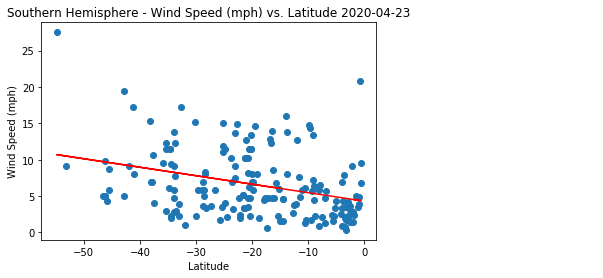

In [50]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

# Create a Scatter Plot for temperature vs latitude
x_values = South_Hem_df['Latitude']
y_values = South_Hem_df['Wind Speed (mph)']

 # Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept
# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

# Create Plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label plot and annotate the line equation
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(line_eq,(20,15),fontsize=15,color="red")
plt.title(f"Southern Hemisphere - Wind Speed (mph) vs. Latitude {date_stamp}")

# Print r square value
print(f"The r-squared is: {rvalue**2}")

plt.savefig("./output_data/SouthernHemisphereWindSpeedVSLatitude.png")
plt.show()